# US Recession prediction

This script contains the the development of a sklearn Support Vector Machine Classifier to predict recession probabilities in the US using Treasury term spreads.

The notebook is organized in the following way:
1) Data Sourcing from Fred
2) Data Manipulation
3) Model selection via grid search (evaluated on Time series Cross Validation)
4) Model evaluation on past recessions
5) Estimation on whole data set and prediction on current edge

# Imports

In [3]:
import pandas_datareader as pdr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score

In [4]:
np.random.seed(42)

# Data Sourcing

## Settings

In [5]:
# features = ['T10Y3M']
# features = ['T10Y2Y']
features = ['T10Y2Y', 'T10Y3M']


In [6]:
start = datetime(1980, 5, 1)
end = datetime(2022, 6, 19)

source_data_list = features.copy()
source_data_list.append('USREC')
df = pdr.DataReader(source_data_list, 'fred', start, end)
df = df.ffill()

df = df.dropna()
df['Null'] = 0

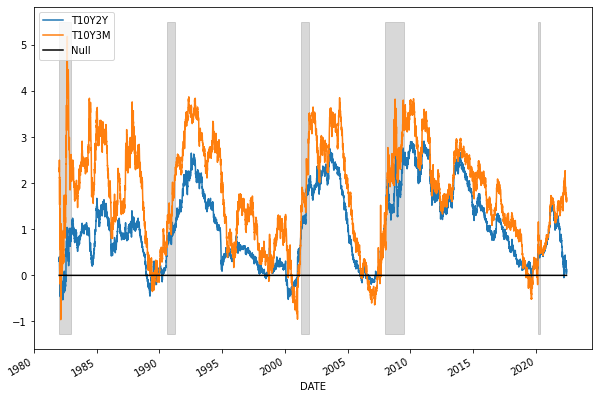

In [7]:
ax = df.plot.line(y=features, figsize=(10,7))
ax = df['Null'].plot(secondary_y=False, color='k')

ax.fill_between(df.index, ax.get_ylim()[0], ax.get_ylim()[1], where=df['USREC'].values, color='gray', alpha=0.3)
ax.legend(loc="upper left")


# Data transformation

In [9]:
df['start_recession'] = df['USREC'] - df['USREC'].shift(1)
df['start_recession'] = df['start_recession'].map(lambda x: np.nan if x != 1 else 1)

In [10]:
df[df['start_recession'] == 1]

,T10Y2Y,T10Y3M,USREC,Null,start_recession
DATE,,,,,
1990-08-01,0.44,0.62,1.0,0,1.0
2001-04-01,0.75,0.63,1.0,0,1.0
2008-01-01,0.99,0.68,1.0,0,1.0
2020-03-01,0.27,-0.14,1.0,0,1.0


In [11]:
df['start_recession_next_12m'] = df['start_recession'].bfill(limit=252).fillna(0)

Careful on current edge:

It is not possible to label "start_recession_12m" for dates in date range (today - 1y, today). Ex: For 02.02.2022, we do not know if a recession starts within 12M after this date, as the 12M period has not yet fully materialized.

In [12]:
# for all dates from today to one year ago we do not know that a recession will not happen
datelist = pd.date_range(end = datetime.today().date(), periods = 360)
df.loc[df.index.isin(datelist), 'start_recession_next_12m'] = None

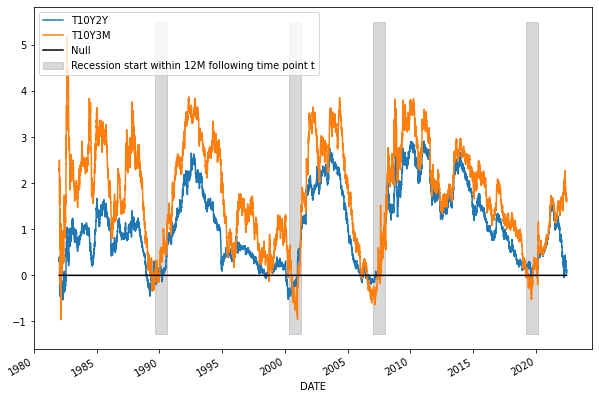

In [13]:
ax = df.plot.line(y=features, figsize=(10,7))
ax = df['Null'].plot(secondary_y=False, color='k')

ax.fill_between(df[~df.index.isin(datelist)].index, ax.get_ylim()[0], ax.get_ylim()[1], 
                where=df.loc[~df.index.isin(datelist), 'start_recession_next_12m'].values, color='gray', alpha=0.3, 
                label='Recession start within 12M following time point t', )
ax.legend(loc="upper left")


# SVM

## data

In [14]:
# drop redundant features
df = df.drop(['start_recession', 'Null', 'USREC'], axis=1)

In [15]:
df_full = df.copy()  # cache dataframe until current edge
print(df.columns)
df = df.dropna()

Index(['T10Y2Y', 'T10Y3M', 'start_recession_next_12m'], dtype='object')


In [16]:
# seperate X-data and target
X = df[features]
y = df['start_recession_next_12m']  


## Model selection: Search for best hyperparameters
The following code block performs a grid search to find optimal hyperparameters for SVM. A TimeSeries-CV (5-folds) is used and the estimators performance is evaluated by accuracy.

In [98]:
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', SVC(probability=True))
])             

# define grid search function
gsc = GridSearchCV(
    estimator=pipe,
    param_grid={
        'clf__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
        'clf__gamma': ['scale', 'auto'],
        'clf__C': [1, 2, 3],
    },
    scoring='accuracy',
    cv=TimeSeriesSplit(n_splits=3)
)

grid_result = gsc.fit(X, y)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: 0.909893 using {'clf__C': 2, 'clf__gamma': 'scale', 'clf__kernel': 'linear'}


... cache optimal params for further runs

In [17]:
# define final params that were found to be optimal from grid search
svm_hyperparams = {'C': 2, 'gamma': 'scale', 'kernel': 'linear'}

## Time series split
This section is optional (as the model selection has been handled by grid search), but kept for convenience. It can be used to double check results from grid search as this section permits to get the average Time-Series-CV accuracy for a SVM with self-specified hyperparameters.

Moreover, the section shows that the performance difference when data is scaled via the StandardScaler before fitting the classifier vs. the performance of the classifier on unfitted data is small. The standardScaler and the pipeline will still be employed which is especially important in the in-practice testing sections of this notebook because of this issue: https://github.com/scikit-learn/scikit-learn/issues/13211 . The classifiers predicted probability over time suffers inconsistencies when data is not preprocessed / standardized.

In [75]:
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC

clf = SVC(**svm_hyperparams, probability=True)

score = cross_val_score(clf, X, y, cv=TimeSeriesSplit(n_splits=5, test_size=1000))

In [76]:
score.mean()

0.9102

In [16]:
# Time Series Cross Validation with preprocessing
pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('clf', SVC(**svm_hyperparams, probability=True))
])

score = cross_val_score(pipe, X, y, cv=TimeSeriesSplit(n_splits=5, test_size=1000))

In [78]:
score.mean()

0.9102

# Final model fit model: In-sample evaluation, then prediction on current edge (out-of-sample)
In next section, a SVM with optimal hyperparameters (according to previous section) is trained on the whole dataset and the in-sample prediction as well as the decision boundry are analysed.

In [17]:
clf = SVC(**svm_hyperparams, probability=True)
clf.fit(X, y)

accuracy_score(clf.predict(X), y)

0.928030666027791

## plot decision boundary in feature space

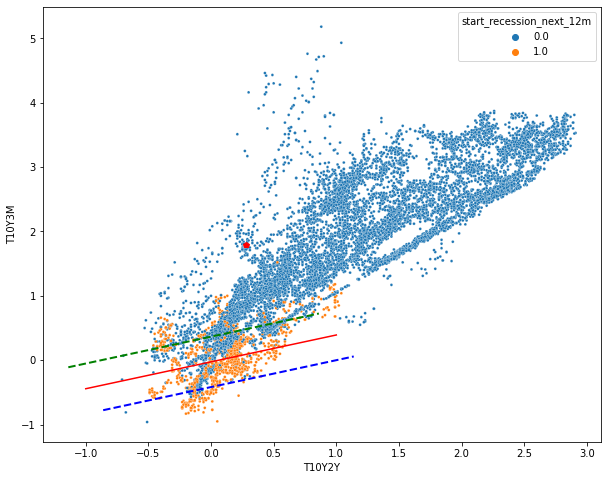

In [80]:
plt.figure(figsize=(10, 8))

# Plotting our two-features-space
sns.scatterplot(x=X.iloc[:, 0], 
                y=X.iloc[:, 1], 
                hue=y, 
                s=8);
# Constructing a hyperplane using a formula.
w = clf.coef_[0]           # w consists of 2 elements
b = clf.intercept_[0]      # b consists of 1 element
x_points = np.linspace(-1, 1)    # generating x-points from -1 to 1
y_points = -(w[0] / w[1]) * x_points - b / w[1]  # getting corresponding y-points
# Plotting a red hyperplane
plt.plot(x_points, y_points, c='r');

# Step 2 (unit-vector):
w_hat = clf.coef_[0] / (np.sqrt(np.sum(clf.coef_[0] ** 2)))
# Step 3 (margin):
margin = 1 / np.sqrt(np.sum(clf.coef_[0] ** 2))
# Step 4 (calculate points of the margin lines):
decision_boundary_points = np.array(list(zip(x_points, y_points)))
points_of_line_above = decision_boundary_points + w_hat * margin
points_of_line_below = decision_boundary_points - w_hat * margin
# Plot margin lines
# Blue margin line above
plt.plot(points_of_line_above[:, 0], 
         points_of_line_above[:, 1], 
         'b--', 
         linewidth=2)
# Green margin line below
plt.plot(points_of_line_below[:, 0], 
         points_of_line_below[:, 1], 
         'g--',
         linewidth=2)

# Plot current Point
plt.plot(df_full.loc[df_full.index.max(), 'T10Y2Y'], 
        df_full.loc[df_full.index.max(), 'T10Y3M'],
        'rp')


In [99]:
df_full.index.max()

Timestamp('2022-06-17 00:00:00')

## plot probability for in sample period
The following block plots the SVM-in-sample-fit-probability that a recession occurs within in 12M after time point t. 

In [81]:
# construct dataframe to cache probability predictions of SVM
df_predict = X.copy()
df_predict['Probability of recession within 12M after time point t'] = [x[1] for x in clf.predict_proba(df_predict[features])]
df_predict['Recession within 12M binary'] = clf.predict(df_predict[features])
df_predict['y_true'] = y

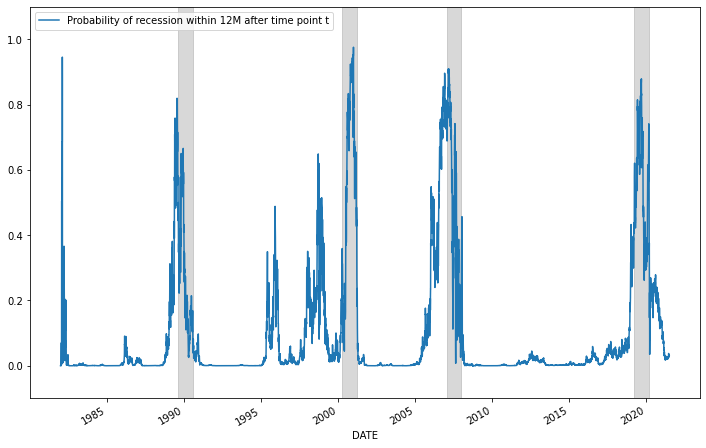

In [82]:
# plot in-sample probability
ax = df_predict['Probability of recession within 12M after time point t'].plot(figsize=(12,8))
#ax = df_predict[['Probability of recession within 12M after time point t', 'Recession within 12M binary']].plot(figsize=(12,8))
#ax.plot(df_predict.index, df_predict['Recession within 12M binary'], color='orange', alpha=0.9, label='Recession within 12M binary = 1')
#ax.fill_between(df_predict.index, 0, 1, where=df_predict['Recession within 12M binary'], color='g', alpha=0.4, label='Recession within 12M binary = 1')
ax.fill_between(df_predict.index, -0.1, 1.1, where=df_predict['y_true'].values, color='gray', alpha=0.3)
ax.set_ylim((-0.1,1.1))
ax.legend(loc="upper left")

## Prediction on current edge

In [83]:
df_current_edge = df_full[df_full.index.isin(datelist)]
X_current_edge = df_current_edge.drop('start_recession_next_12m', axis=1)

In [84]:
# construct dataframe to cache probability predictions of SVM
df_predict_current_edge = X_current_edge.copy()
df_predict_current_edge['y_pred'] = [x[1] for x in clf.predict_proba(X_current_edge)]

(0.0, 1.0)

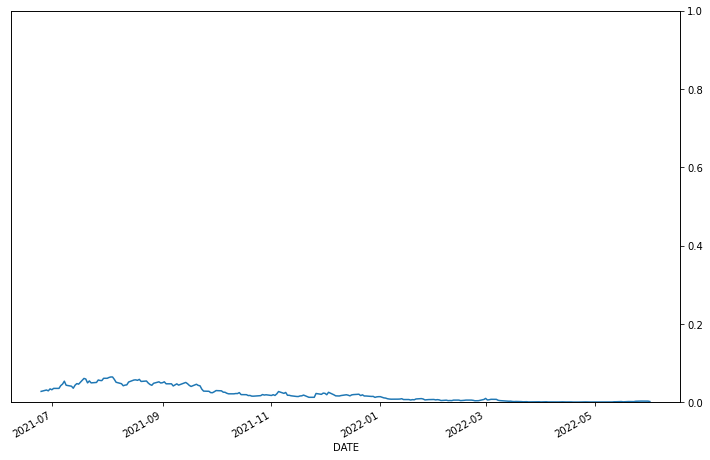

In [85]:
#df_predict.plot(kind='line', y=['T10Y2Y', 'T10Y3M' ]);
ax = df_predict_current_edge['y_pred'].plot(secondary_y=True, figsize=(12,8))
ax.set_ylim((0,1))

# In-practice evaluation: Train 1980-2000, Test Second recession (start: May 2001)

In [18]:
train_date_range = pd.date_range(start=start, end=pd.to_datetime('2000-01-01'))
test_date_range = pd.date_range(start=pd.to_datetime('2000-01-02'), end=pd.to_datetime('2006-01-01'))
train_date_range

DatetimeIndex(['1980-05-01', '1980-05-02', '1980-05-03', '1980-05-04',
               '1980-05-05', '1980-05-06', '1980-05-07', '1980-05-08',
               '1980-05-09', '1980-05-10',
               ...
               '1999-12-23', '1999-12-24', '1999-12-25', '1999-12-26',
               '1999-12-27', '1999-12-28', '1999-12-29', '1999-12-30',
               '1999-12-31', '2000-01-01'],
              dtype='datetime64[ns]', length=7185, freq='D')

In [19]:
# Train and test dataframes
df_train = df[df.index.isin(train_date_range)]
df_test = df[df.index.isin(test_date_range)]

X_train = df_train[features]
y_train = df_train['start_recession_next_12m']

X_test = df_test[features]
y_test = df_test['start_recession_next_12m']

In [20]:

pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('clf', SVC(**svm_hyperparams, probability=True))
])

pipe.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('clf', SVC(C=2, kernel='linear', probability=True))])

## evaluation

In [21]:
#y_pred_prob = clf.predict_proba(X_test)
#y_pred = clf.predict(X_test)
y_pred_prob = pipe.predict_proba(X_test)
y_pred = pipe.predict(X_test)

In [22]:
# Save results
results = X_test.copy()
results['Probability of recession within 12M after time point t'] = [x[1] for x in y_pred_prob]
results['Recession within 12M binary'] = y_pred
results['y_true'] = y_test

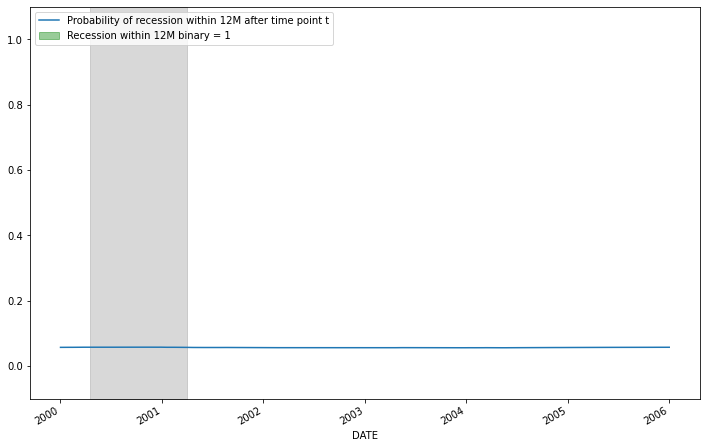

In [23]:
# plot out-of-sample probability
ax = results['Probability of recession within 12M after time point t'].plot(figsize=(12,8))
ax.fill_between(results.index, -0.1, 1.1, where=results['Recession within 12M binary'], color='g', alpha=0.4, label='Recession within 12M binary = 1')
ax.fill_between(results.index, -0.1, 1.1, where=results['y_true'].values, color='gray', alpha=0.3)
ax.set_ylim((-0.1,1.1))
ax.legend(loc="upper left")


### calculate statistics

In [24]:
print('SVM accuracy for out-of-sample period', round(accuracy_score(y_pred, y_test) * 100, 1), '%')
print('SVM precision for out-of-sample period', round(precision_score(y_pred, y_test) * 100, 1), '%')
print('SVM precision for out-of-sample period', round(recall_score(y_test, y_pred) * 100, 1), '%')

SVM accuracy for out-of-sample period 84.0 %
SVM precision for out-of-sample period 0.0 %
SVM precision for out-of-sample period 0.0 %


## bad performance: Why?
Too small sample size of training data?

As there is only the information about one recession in the training set the one could presume that this is the cause for the bad performance. Thus in the following, a Machine-Learning NO-GO is performed to get an indication if the bad performance is really caused by a lack of data.

In [26]:
# define date range used for training and testing
test_date_range = pd.date_range(start=pd.to_datetime('2000-01-02'), end=pd.to_datetime('2006-06-01'))

# split dataset. Here we only have test_date_range thus we split test_date_range from whole dataset and use the rest as training data
X_train = df[~df.index.isin(test_date_range)][features]
y_train = df[~df.index.isin(test_date_range)]['start_recession_next_12m']

X_test = df[df.index.isin(test_date_range)][features]
y_test = df[df.index.isin(test_date_range)]['start_recession_next_12m']

In [27]:
# fit model to newly splitted data
pipe.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('clf', SVC(C=2, kernel='linear', probability=True))])

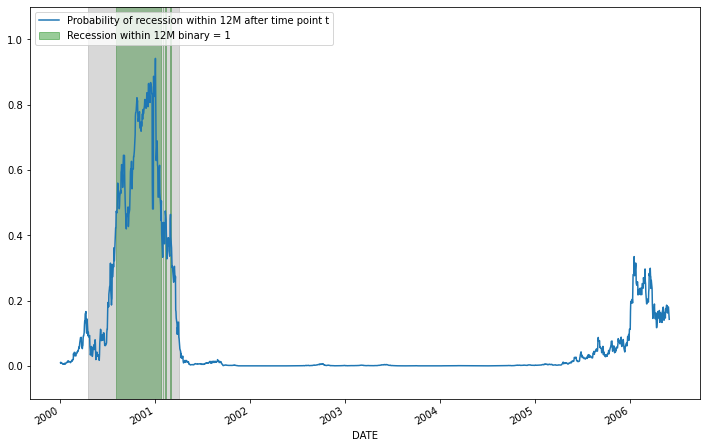

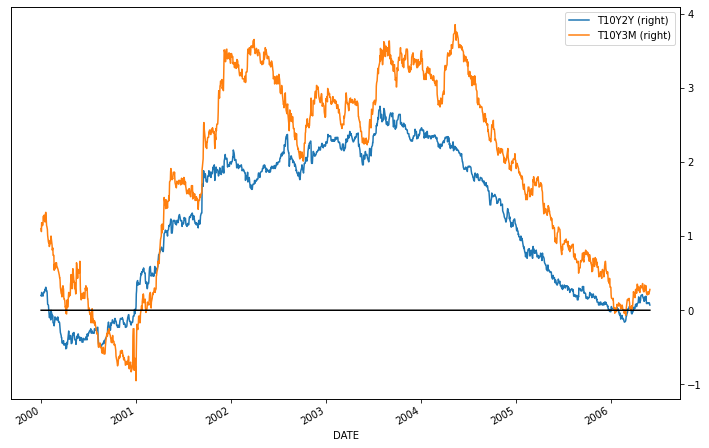

In [28]:
# predict out-of-sample
y_proba = pipe.predict_proba(X_test)
y_pred = pipe.predict(X_test)

# Save results
results = X_test.copy()
results['Probability of recession within 12M after time point t'] = [x[1] for x in y_proba]
results['Recession within 12M binary'] = y_pred
results['y_true'] = y_test

# plot out-of-sample probability and binary prediction
ax = results['Probability of recession within 12M after time point t'].plot(figsize=(12,8))
ax.fill_between(results.index, -0.1, 1.1, where=results['Recession within 12M binary'], color='g', alpha=0.4, label='Recession within 12M binary = 1')
ax.fill_between(results.index, -0.1, 1.1, where=results['y_true'].values, color='gray', alpha=0.3)
ax.set_ylim((-0.1,1.1))
ax.legend(loc="upper left")
ax1 = X_test.plot(kind='line', y=['T10Y2Y', 'T10Y3M'], secondary_y=True, figsize=(12,8))
ax1.plot(X_test.index, np.zeros(X_test.shape[0]), color='black')

In [29]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score

print('SVM accuracy for out-of-sample period', round(accuracy_score(y_test, y_pred) * 100, 1), '%')
print('SVM precision for out-of-sample period', round(precision_score(y_test, y_pred) * 100, 1), '%')
print('SVM precision for out-of-sample period', round(recall_score(y_test, y_pred) * 100, 1), '%')

SVM accuracy for out-of-sample period 93.2 %
SVM precision for out-of-sample period 100.0 %
SVM precision for out-of-sample period 54.2 %


# Training: 1980-2006 Test: 2006-2012 (in practice)

## training

In [40]:
train_date_range = pd.date_range(start=start, end=pd.to_datetime('2006-01-01'))
test_date_range = pd.date_range(start=pd.to_datetime('2006-01-02'), end=pd.to_datetime('2012-01-01'))
train_date_range

DatetimeIndex(['1980-05-01', '1980-05-02', '1980-05-03', '1980-05-04',
               '1980-05-05', '1980-05-06', '1980-05-07', '1980-05-08',
               '1980-05-09', '1980-05-10',
               ...
               '2005-12-23', '2005-12-24', '2005-12-25', '2005-12-26',
               '2005-12-27', '2005-12-28', '2005-12-29', '2005-12-30',
               '2005-12-31', '2006-01-01'],
              dtype='datetime64[ns]', length=9377, freq='D')

In [41]:
# Train and test dataframes
df_train = df[df.index.isin(train_date_range)]
df_test = df[df.index.isin(test_date_range)]

X_train = df_train[features]
y_train = df_train['start_recession_next_12m']

X_test = df_test[features]
y_test = df_test['start_recession_next_12m']

In [42]:
# fit previously defined pipeline to new data setup
pipe.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('clf', SVC(C=2, kernel='linear', probability=True))])

## evaluation

In [43]:
y_pred_proba = pipe.predict_proba(X_test)
y_pred = pipe.predict(X_test)

# Save results
results = X_test.copy()
results['Probability of recession within 12M after time point t'] = [x[1] for x in y_pred_proba]
results['Recession within 12M binary'] = y_pred
results['y_true'] = y_test

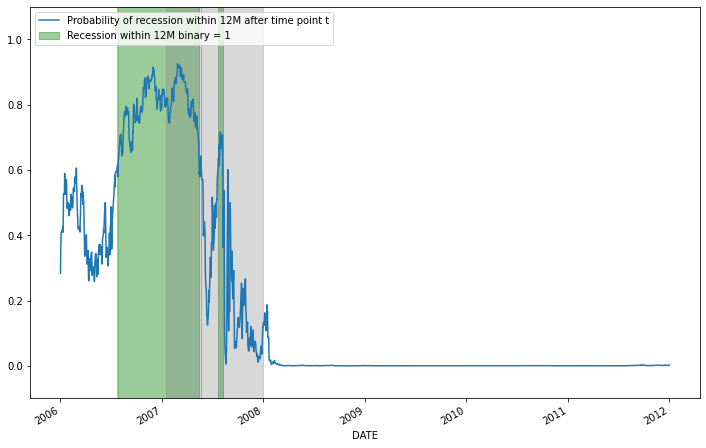

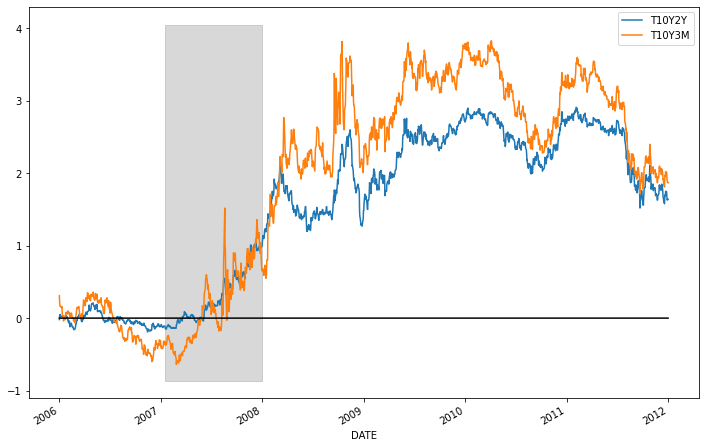

In [44]:
# plot out-of-sample probability
ax = results['Probability of recession within 12M after time point t'].plot(figsize=(12,8))
ax.fill_between(results.index, -0.1, 1.1, where=results['Recession within 12M binary'], color='g', alpha=0.4, label='Recession within 12M binary = 1')
ax.fill_between(results.index, -0.1, 1.1, where=results['y_true'].values, color='gray', alpha=0.3)
ax.set_ylim((-0.1,1.1))
ax.legend(loc="upper left")
ax1 = X_test.plot(kind='line', y=['T10Y2Y', 'T10Y3M'], figsize=(12,8))
ax1.plot(X_test.index, np.zeros(X_test.shape[0]), color='black')
ax1.fill_between(results.index, ax1.get_ylim()[0], ax1.get_ylim()[1], where=results['y_true'].values, color='gray', alpha=0.3)

### calculate statistics

In [47]:
print('SVM accuracy for out-of-sample period', round(accuracy_score(y_test, y_pred) * 100, 1), '%')
print('SVM precision for out-of-sample period', round(precision_score(y_test, y_pred) * 100, 1), '%')
print('SVM precision for out-of-sample period', round(recall_score(y_test, y_pred) * 100, 1), '%')

SVM accuracy for out-of-sample period 82.3 %
SVM precision for out-of-sample period 44.0 %
SVM precision for out-of-sample period 39.1 %


Sample Size 1585


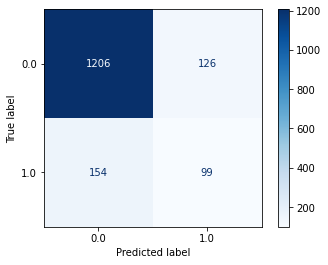

In [48]:
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

print('Sample Size', X_test.shape[0])

# construct confusion matrix 
cm = confusion_matrix(y_true=y_test, y_pred=y_pred, labels=pipe['clf'].classes_,
                     )
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=pipe['clf'].classes_,
                              )
disp.plot(cmap=plt.cm.Blues)

plt.show()

# Training: 1980-2018 Test: 2018-2022 (in practice)

## training

In [54]:
train_date_range = pd.date_range(start=start, end=pd.to_datetime('2018-01-01'))
test_date_range = pd.date_range(start=pd.to_datetime('2018-01-02'), end=pd.to_datetime('2022-01-01'))
train_date_range

DatetimeIndex(['1980-05-01', '1980-05-02', '1980-05-03', '1980-05-04',
               '1980-05-05', '1980-05-06', '1980-05-07', '1980-05-08',
               '1980-05-09', '1980-05-10',
               ...
               '2017-12-23', '2017-12-24', '2017-12-25', '2017-12-26',
               '2017-12-27', '2017-12-28', '2017-12-29', '2017-12-30',
               '2017-12-31', '2018-01-01'],
              dtype='datetime64[ns]', length=13760, freq='D')

In [55]:
# Train and test dataframes
df_train = df[df.index.isin(train_date_range)]
df_test = df[df.index.isin(test_date_range)]

X_train = df_train[features]
y_train = df_train['start_recession_next_12m']

X_test = df_test[features]
y_test = df_test['start_recession_next_12m']

In [56]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('clf', SVC(C=2, kernel='linear', probability=True))])

## evaluation

In [57]:
y_pred_proba = pipe.predict_proba(X_test)
y_pred = pipe.predict(X_test)

# Save results
results = X_test.copy()
results['Probability of recession within 12M after time point t'] = [x[1] for x in y_pred_proba]
results['Recession within 12M binary'] = y_pred
results['y_true'] = y_test

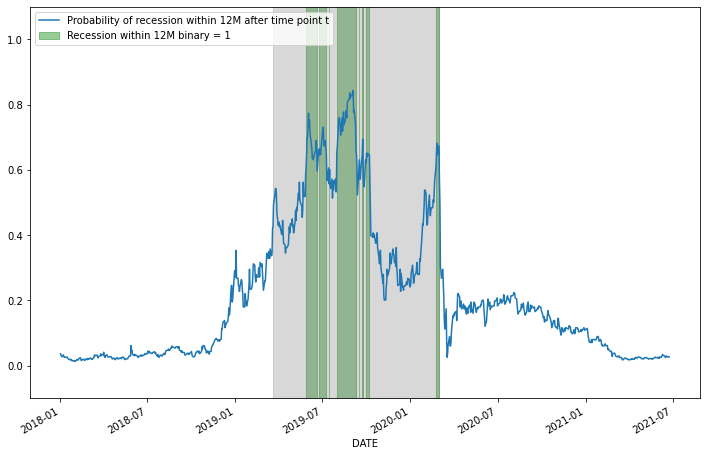

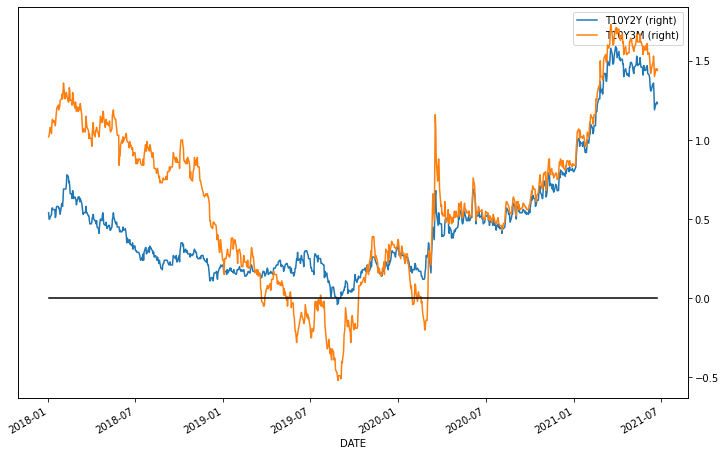

In [58]:
# plot out-of-sample probability
ax = results['Probability of recession within 12M after time point t'].plot(figsize=(12,8))
ax.fill_between(results.index, -0.1, 1.1, where=results['Recession within 12M binary'], color='g', alpha=0.4, label='Recession within 12M binary = 1')
ax.fill_between(results.index, -0.1, 1.1, where=results['y_true'].values, color='gray', alpha=0.3)
ax.set_ylim((-0.1,1.1))
ax.legend(loc="upper left")
ax1 = X_test.plot(kind='line', y=['T10Y2Y', 'T10Y3M'], secondary_y=True, figsize=(12,8))
ax1.plot(X_test.index, np.zeros(X_test.shape[0]), color='black')

### calculate statistics

In [62]:
print('SVM accuracy for out-of-sample period', round(accuracy_score(y_test, y_pred) * 100, 1), '%')
print('SVM precision for out-of-sample period', round(precision_score(y_test, y_pred) * 100, 1), '%')
print('SVM recall for out-of-sample period', round(recall_score(y_test, y_pred) * 100, 1), '%')

SVM accuracy for out-of-sample period 81.2 %
SVM precision for out-of-sample period 100.0 %
SVM recall for out-of-sample period 31.6 %


Sample Size 920


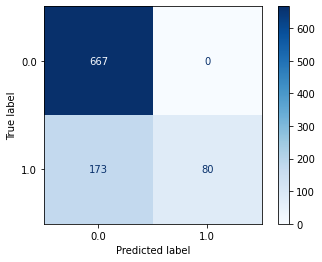

In [60]:
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

print('Sample Size', X_test.shape[0])

# construct confusion matrix 
cm = confusion_matrix(y_true=y_test, y_pred=y_pred, labels=pipe['clf'].classes_,
                     )
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=pipe['clf'].classes_,
                              )
disp.plot(cmap=plt.cm.Blues)

plt.show()